In [133]:
# Import library untuk EDA dan visualisasi multimodal
import os  # operasi sistem dan path
import numpy as np  # komputasi numerik
import pandas as pd  # manipulasi data tabular
import matplotlib.pyplot as plt  # visualisasi
import seaborn as sns  # heatmap/korelasi
from sklearn.preprocessing import StandardScaler  # standardisasi fitur
from sklearn.decomposition import PCA  # reduksi dimensi linear
from sklearn.manifold import TSNE  # reduksi dimensi non-linear (t-SNE)
from sklearn.feature_extraction.text import TfidfVectorizer  # representasi teks (lyric) berbasis TF-IDF
import librosa  # pemrosesan dan ekstraksi fitur audio
import pretty_midi  # pemrosesan dan ekstraksi fitur MIDI (pip install pretty_midi jika belum terpasang)


In [134]:
# Atur path root dataset (ubah jika lokasi berbeda)
root_dir = r"D:\Se\Multimodal\TUBES\dataset"  # ganti sesuai lokasi dataset Anda

# Tampilkan isi folder agar tahu nama subfolder dan file yang tersedia
print("Isi root_dir:")
for item in os.listdir(root_dir):
    print('-', item)

# Catatan: jika nama folder atau file berbeda, sesuaikan di cell berikutnya.

Isi root_dir:
- Audio
- categories.txt
- clusters.txt
- dataset info.csv
- dataset info.html
- Lyrics
- MIDIs
- split-by-categories-audio.bat
- split-by-categories-lyrics.bat
- split-by-categories-midi.bat


In [135]:
# Set path untuk folder audio, MIDI, lirik, dan file metadata/label
# Ganti nama folder jika berbeda (huruf besar/kecil di Windows tidak masalah, di Linux sensitif)
audio_dir = os.path.join(root_dir, "Audio")
midi_dir = os.path.join(root_dir, "MIDIs")
lyrics_dir = os.path.join(root_dir, "Lyrics")

# File metadata utama bernama "dataset info.csv"
csv_path = os.path.join(root_dir, "dataset info.csv")

# Label kategori emosi utama
cat_path = os.path.join(root_dir, "categories.txt")

# Label alternatif (clusters)
cluster_path = os.path.join(root_dir, "clusters.txt")

print("Folder audio:", audio_dir)
print("Folder MIDI:", midi_dir)
print("Folder lyrics:", lyrics_dir)
print("File metadata CSV:", csv_path)
print("File label emosi:", cat_path)
print("File label clusters:", cluster_path)

Folder audio: D:\Se\Multimodal\TUBES\dataset\Audio
Folder MIDI: D:\Se\Multimodal\TUBES\dataset\MIDIs
Folder lyrics: D:\Se\Multimodal\TUBES\dataset\Lyrics
File metadata CSV: D:\Se\Multimodal\TUBES\dataset\dataset info.csv
File label emosi: D:\Se\Multimodal\TUBES\dataset\categories.txt
File label clusters: D:\Se\Multimodal\TUBES\dataset\clusters.txt


In [136]:
# Baca metadata CSV dan file label (kategori + cluster)
metadata = pd.read_csv(csv_path, sep=';', engine='python', encoding='utf-16', on_bad_lines='skip')

# Bersihkan kolom yang tidak diperlukan
if 'Unnamed: 9' in metadata.columns:
    metadata = metadata.drop(columns=['Unnamed: 9'])

# Samakan nama kolom filename agar konsisten
if 'Filename' in metadata.columns:
    metadata = metadata.rename(columns={'Filename': 'filename'})

# Baca label emosi dari categories.txt
with open(cat_path, 'r', encoding='latin-1') as f:
    categories = [line.strip() for line in f if line.strip()]

# Baca label cluster dari clusters.txt
with open(cluster_path, 'r', encoding='latin-1') as f:
    clusters = [line.strip() for line in f if line.strip()]

# Samakan panjang metadata dan label (jaga-jaga jika ada baris rusak)
min_len = min(len(metadata), len(categories), len(clusters))
if len({len(metadata), len(categories), len(clusters)}) != 1:
    print(f"Peringatan: panjang metadata ({len(metadata)}), categories ({len(categories)}), clusters ({len(clusters)}); memakai {min_len} baris pertama.")
metadata = metadata.iloc[:min_len].copy()
metadata['label'] = categories[:min_len]
metadata['cluster'] = clusters[:min_len]

print("Head metadata:")
print(metadata.head())
print("Kolom tersedia:", list(metadata.columns))

# Pastikan kolom nama file audio ("filename") dan kolom label ("label"/"cluster") sudah ada.

Peringatan: panjang metadata (902), categories (903), clusters (903); memakai 902 baris pertama.
Head metadata:
                                 Title                             Artist  \
0  (Mama) He Treats Your Daughter Mean                        Brown, Ruth   
1                     Night in Tunisia  Blakey, Art & the Jazz Messengers   
2                     Along Came Jones                           Coasters   
3                        Back in Black                              AC/DC   
4                       Bad Reputation       Jett, Joan & Teh Blackhearts   

                             Album  Track    Year  Length       Size  \
0       Best of Ruth Brown [Rhino]    8.0  1996.0      30  352,00 KB   
1          Night in Tunisia [1960]    1.0  1960.0      30  348,00 KB   
2  50 Coastin' Classics: Anthology   27.0  1992.0      30  352,00 KB   
3                    Back in Black    6.0  1980.0      30  352,00 KB   
4    Bad Reputation [Bonus Tracks]    1.0  1992.0      29  340,00

In [137]:
# Distribusi label kategori dan cluster
print("Distribusi kategori (categories.txt):")
print(metadata['label'].value_counts())
print("Distribusi cluster (clusters.txt):")
print(metadata['cluster'].value_counts())

Distribusi kategori (categories.txt):
label
Passionate              40
Literate                39
Campy                   38
Bittersweet             38
Confident               37
Wry                     37
Autumnal                36
Brooding                36
Sweet                   35
Amiable-good natured    35
Wistful                 34
whimsical               34
Rousing                 33
Rollicking              33
Poignant                32
Cheerful                32
Visceral                32
Witty                   32
Tense - Anxious         31
Boisterous              31
Fun                     29
Rowdy                   29
Silly                   28
Fiery                   26
Volatile                26
Intense                 25
Humorous                22
Agressive               22
Name: count, dtype: int64
Distribusi cluster (clusters.txt):
cluster
Cluster 3    215
Cluster 4    191
Cluster 1    170
Cluster 2    164
Cluster 5    162
Name: count, dtype: int64


In [138]:
# Cek ketersediaan berkas per modal dibanding metadata
base_names = metadata['filename'].astype(str).apply(lambda x: os.path.splitext(x)[0])
audio_files = set([os.path.splitext(f)[0] for f in os.listdir(audio_dir) if f.lower().endswith('.mp3')])
midi_files = set([os.path.splitext(f)[0] for f in os.listdir(midi_dir) if f.lower().endswith('.mid')])
lyrics_files = set([os.path.splitext(f)[0] for f in os.listdir(lyrics_dir) if f.lower().endswith('.txt')])

missing_audio = [b for b in base_names if b not in audio_files]
missing_midi = [b for b in base_names if b not in midi_files]
missing_lyrics = [b for b in base_names if b not in lyrics_files]

print(f"Total baris metadata: {len(base_names)}")
print(f"Audio tersedia: {len(audio_files)} ({len(base_names) - len(missing_audio)} dipakai) | hilang terhadap metadata: {len(missing_audio)}")
print(f"MIDI tersedia: {len(midi_files)} ({len(base_names) - len(missing_midi)} dipakai) | hilang terhadap metadata: {len(missing_midi)}")
print(f"Lyrics tersedia: {len(lyrics_files)} ({len(base_names) - len(missing_lyrics)} dipakai) | hilang terhadap metadata: {len(missing_lyrics)}")
print("Contoh missing MIDI:", missing_midi[:10])
print("Contoh missing Lyrics:", missing_lyrics[:10])

# Jika banyak hilang, dataset unduhan Anda memang tidak menyediakan modal tersebut untuk semua lagu.

Total baris metadata: 902
Audio tersedia: 903 (902 dipakai) | hilang terhadap metadata: 0
MIDI tersedia: 196 (196 dipakai) | hilang terhadap metadata: 706
Lyrics tersedia: 764 (764 dipakai) | hilang terhadap metadata: 138
Contoh missing MIDI: ['001', '002', '003', '005', '006', '007', '010', '011', '013', '014']
Contoh missing Lyrics: ['002', '005', '006', '014', '018', '023', '026', '031', '035', '047']


In [139]:
# Ekstraksi fitur audio (MFCC) tanpa encoder deep learning
feature_list = []
label_list = []
cluster_list = []
audio_durations = []

for idx, row in metadata.iterrows():
    audio_path = os.path.join(audio_dir, str(row['filename']))

    if not os.path.isfile(audio_path):
        continue  # skip jika file tidak ada

    try:
        signal, sr = librosa.load(audio_path, sr=None)
        duration_sec = len(signal) / sr

        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)
        features = np.concatenate([mfcc_mean, mfcc_std])

        feature_list.append(features)
        label_list.append(row['label'])
        cluster_list.append(row['cluster'])
        audio_durations.append(duration_sec)
    except Exception as e:
        print(f"Gagal memproses {audio_path}: {e}")
        continue

X_audio = np.array(feature_list)
y_audio = np.array(label_list)
y_audio_cluster = np.array(cluster_list)

audio_durations = np.array(audio_durations)

print("Shape fitur X_audio:", X_audio.shape)
print("Contoh baris fitur:")
print(X_audio[:5])
print("Contoh label kategori:", y_audio[:10])
print("Contoh label cluster:", y_audio_cluster[:10])
print("Contoh durasi audio (detik):", audio_durations[:5])


Shape fitur X_audio: (902, 40)
Contoh baris fitur:
[[-1.6785114e+02  1.1701219e+02 -1.9130047e+01  5.2945614e+01
  -8.8185167e+00  1.9084713e+01 -1.5262511e+01  2.0636452e+01
  -1.0908054e+01  1.3767481e+00 -4.4525108e+00  2.2149341e+00
  -2.2924769e+00 -3.5306246e+00  3.8196149e+00 -9.3648577e+00
   6.1573739e+00 -7.5067644e+00  3.1823032e+00  9.5210427e-01
   8.5305756e+01  3.1342798e+01  2.9843019e+01  2.0273891e+01
   2.0565620e+01  1.3792289e+01  1.3869272e+01  1.2004803e+01
   1.1391359e+01  1.2239429e+01  1.0517929e+01  9.6439762e+00
   7.8007879e+00  8.3086824e+00  6.9684157e+00  8.9800005e+00
   8.9130602e+00  9.0683002e+00  9.2658558e+00  9.6373081e+00]
 [-3.0501196e+02  1.4610637e+02  1.7744226e+01  5.7188725e+01
   6.5879588e+00  2.9418921e+01  6.0536380e+00  9.0215216e+00
   2.8273447e+00  6.6681042e+00  3.0126431e+00 -9.8925382e-01
   8.7320071e-01 -6.1420398e-03  3.5632050e+00 -1.9301555e-01
   2.8221614e+00 -9.2385358e-01  4.1387568e+00  3.5894054e-01
   9.7046288e+01  

In [140]:
# Standardisasi fitur audio
scaler_audio = StandardScaler()
X_audio_scaled = scaler_audio.fit_transform(X_audio)

print("Shape X_audio_scaled:", X_audio_scaled.shape)
# Standardisasi membantu algoritma berbasis jarak (seperti PCA dan t-SNE) bekerja lebih stabil.

Shape X_audio_scaled: (902, 40)


In [141]:
# Reduksi dimensi awal dengan PCA sebelum t-SNE (audio)
pca_audio = PCA(n_components=30, random_state=42)
X_audio_pca = pca_audio.fit_transform(X_audio_scaled)

print("Shape X_audio_pca:", X_audio_pca.shape)
explained_var_audio = np.sum(pca_audio.explained_variance_ratio_)
print(f"Total variansi yang dijelaskan 30 komponen pertama: {explained_var_audio:.2%}")

# PCA membantu mereduksi noise dan mempercepat t-SNE dengan mempertahankan informasi utama.

Shape X_audio_pca: (902, 30)
Total variansi yang dijelaskan 30 komponen pertama: 95.56%


In [142]:
# Jalankan t-SNE utama (audio) menggunakan seluruh data
_tsne_audio = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    n_iter=1000,
    random_state=42,
    init='pca'
)
X_audio_tsne = _tsne_audio.fit_transform(X_audio_pca)

print("Shape X_audio_tsne:", X_audio_tsne.shape)

# Parameter utama t-SNE:
# - perplexity: kira-kira jumlah tetangga efektif yang diperhatikan (skala lokal)
# - learning_rate: kecepatan pembaruan posisi
# - n_iter: jumlah iterasi optimisasi

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Shape X_audio_tsne: (902, 2)


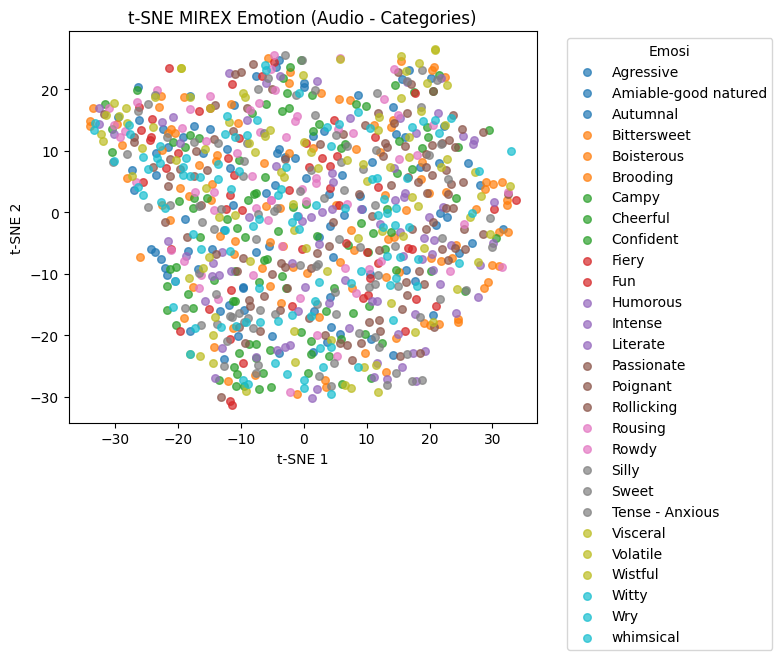

In [143]:
# Visualisasi t-SNE audio berwarna sesuai label kategori
plt.figure(figsize=(8, 6))
unique_labels = np.unique(y_audio)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
label_to_color = {label: color for label, color in zip(unique_labels, colors)}

for label in unique_labels:
    mask = y_audio == label
    plt.scatter(X_audio_tsne[mask, 0], X_audio_tsne[mask, 1],
                color=label_to_color[label], alpha=0.7, label=label, s=30)

plt.title('t-SNE MIREX Emotion (Audio - Categories)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Emosi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Titik yang dekat merepresentasikan klip audio dengan pola MFCC mirip; warna = kategori emosi.

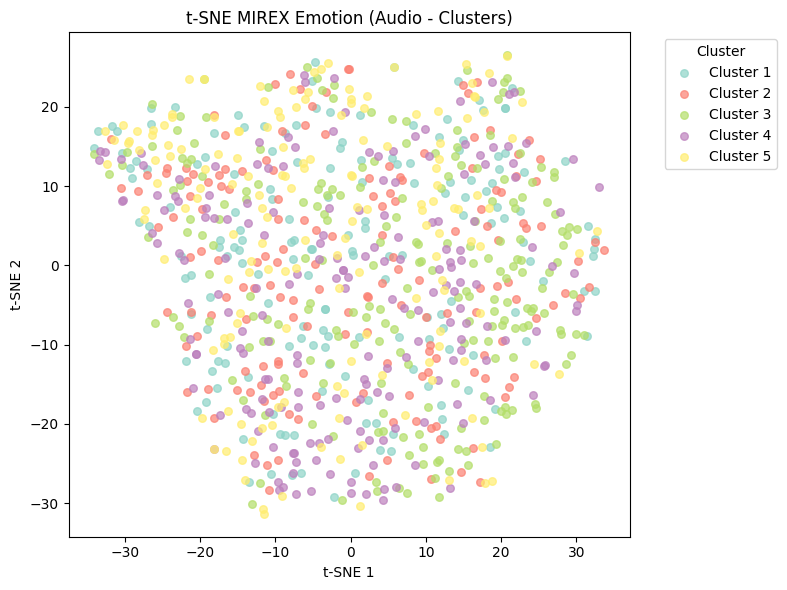

In [144]:
# Visualisasi t-SNE audio dengan label cluster
plt.figure(figsize=(8, 6))
unique_clusters = np.unique(y_audio_cluster)
colors_c = plt.cm.Set3(np.linspace(0, 1, len(unique_clusters)))
cluster_to_color = {c: color for c, color in zip(unique_clusters, colors_c)}

for c in unique_clusters:
    mask = y_audio_cluster == c
    plt.scatter(X_audio_tsne[mask, 0], X_audio_tsne[mask, 1],
                color=cluster_to_color[c], alpha=0.7, label=c, s=30)

plt.title('t-SNE MIREX Emotion (Audio - Clusters)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot ini membantu melihat apakah label alternatif (clusters.txt) memberi struktur berbeda.

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


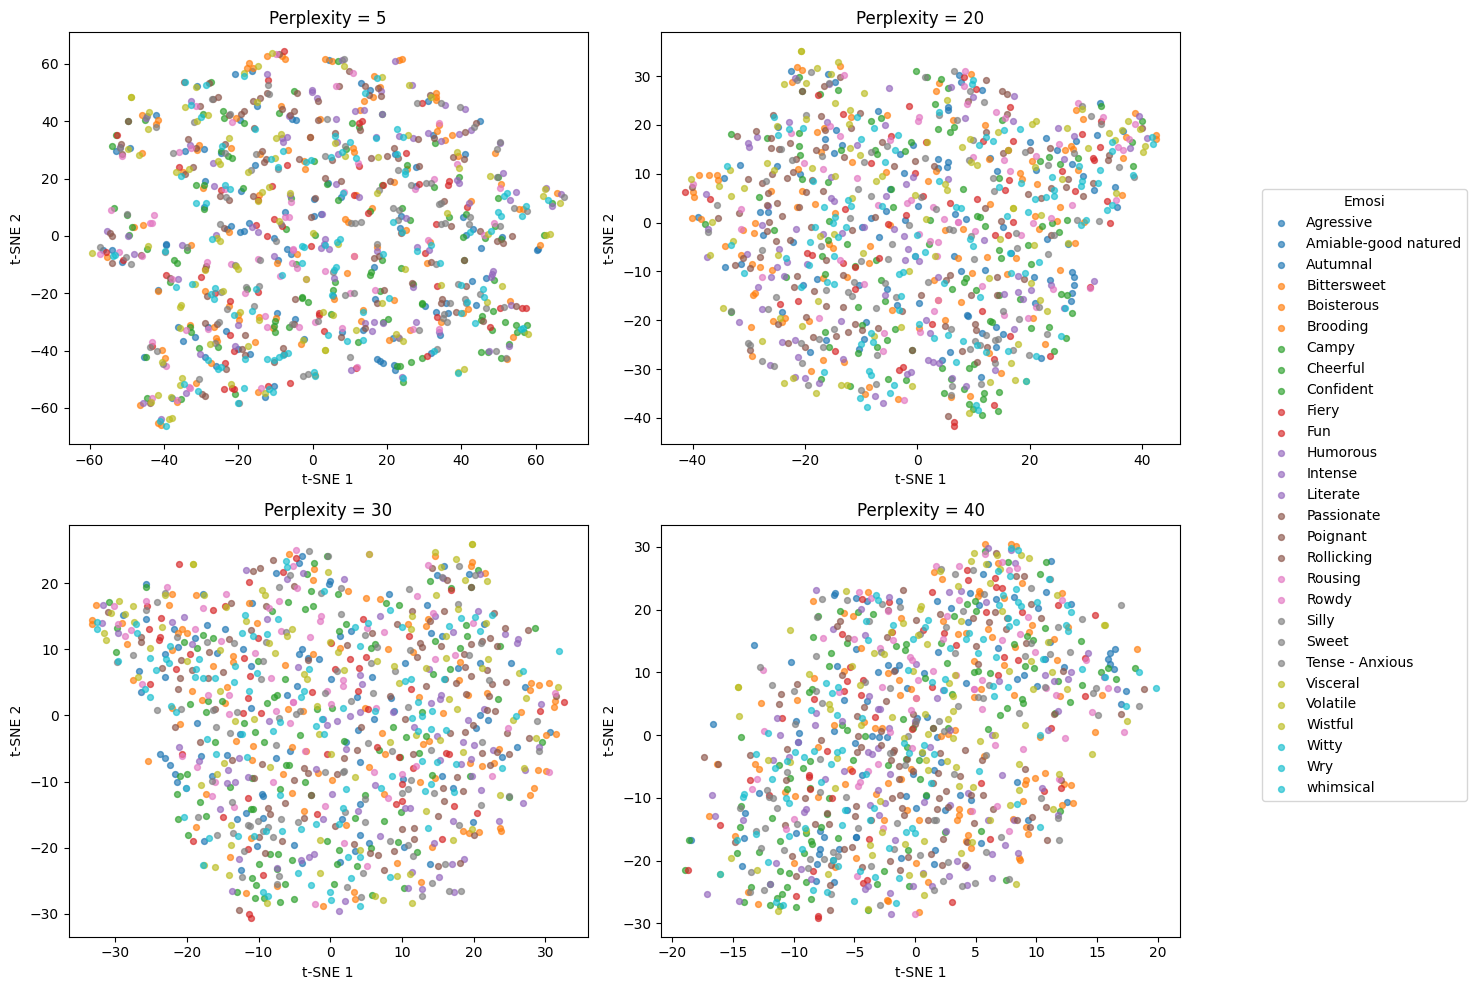

In [145]:
# Eksperimen variasi perplexity t-SNE (audio) memakai seluruh data
perplexities = [5, 20, 30, 40]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, perp in zip(axes, perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, learning_rate=200, n_iter=800, random_state=42, init='pca')
    X_tsne_var = tsne.fit_transform(X_audio_pca)

    unique_labels_var = np.unique(y_audio)
    colors_var = plt.cm.tab10(np.linspace(0, 1, len(unique_labels_var)))
    label_to_color_var = {label: color for label, color in zip(unique_labels_var, colors_var)}

    for label in unique_labels_var:
        mask = y_audio == label
        ax.scatter(X_tsne_var[mask, 0], X_tsne_var[mask, 1],
                   color=label_to_color_var[label], alpha=0.65, s=18, label=label)

    ax.set_title(f"Perplexity = {perp}")
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Emosi', bbox_to_anchor=(1.05, 0.5), loc='center left')
plt.tight_layout()
plt.show()

# Perplexity kecil fokus lokal, besar fokus struktur lebih global. Pilih yang paling stabil di beberapa nilai.

### Catatan tentang Perplexity
Perplexity di t-SNE adalah ukuran kira-kira berapa banyak tetangga efektif yang dipertimbangkan saat memproyeksikan data.
- Nilai kecil (mis. 5) fokus struktur lokal, membentuk cluster kecil tapi bisa memutus hubungan global.
- Nilai sedang (20?40) sering jadi awal seimbang lokal vs global.
- Nilai terlalu besar bisa melebur cluster kecil; terlalu kecil bisa berisik/terpecah. Bandingkan plot variasi di atas untuk memilih nilai stabil.

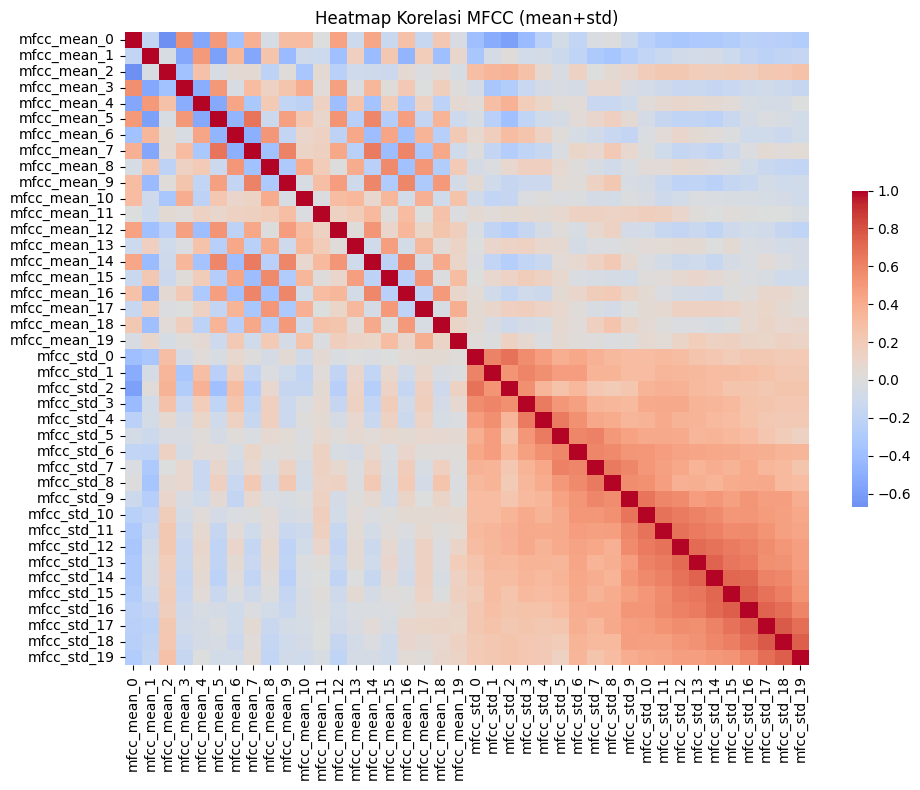

In [146]:
# Korelasi fitur MFCC ringkas (mean+std)
if X_audio.shape[1] >= 2:
    mfcc_df = pd.DataFrame(X_audio, columns=[f'mfcc_mean_{i}' for i in range(20)] + [f'mfcc_std_{i}' for i in range(20)])
    corr = mfcc_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', center=0, cbar_kws={'shrink': 0.5})
    plt.title('Heatmap Korelasi MFCC (mean+std)')
    plt.tight_layout()
    plt.show()
else:
    print('Tidak cukup fitur untuk korelasi MFCC.')


### Catatan tentang PCA scree plot
Scree plot memperlihatkan variansi yang dijelaskan tiap komponen. Cari titik lutut (elbow) untuk menentukan jumlah komponen yang cukup sebelum t-SNE.

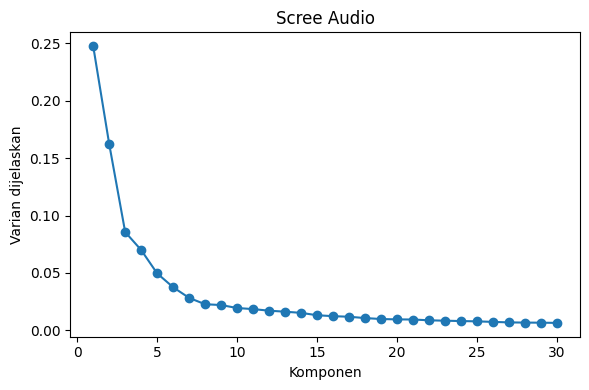

In [147]:
# Scree plot PCA audio
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, len(pca_audio.explained_variance_ratio_)+1), pca_audio.explained_variance_ratio_, marker='o')
plt.title('Scree Audio')
plt.xlabel('Komponen')
plt.ylabel('Varian dijelaskan')
plt.tight_layout()
plt.show()


In [148]:
# Ekstraksi fitur MIDI sederhana (tanpa encoder)
midi_features = []
midi_labels = []
midi_clusters = []
midi_note_counts = []
missing_midi_count = 0

for idx, row in metadata.iterrows():
    base = os.path.splitext(str(row['filename']))[0]
    midi_path = os.path.join(midi_dir, base + '.mid')

    if not os.path.isfile(midi_path):
        missing_midi_count += 1
        continue

    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
        notes = []
        for inst in pm.instruments:
            notes.extend(inst.notes)

        if len(notes) == 0:
            continue

        pitches = np.array([n.pitch for n in notes])
        velocities = np.array([n.velocity for n in notes])
        durations = np.array([n.end - n.start for n in notes])

        _, tempi = pm.get_tempo_changes()
        tempo_mean = float(np.mean(tempi)) if len(tempi) > 0 else 0.0

        feat = np.array([
            len(notes),
            pitches.mean(), pitches.std(),
            velocities.mean(), velocities.std(),
            durations.mean(), durations.std(),
            tempo_mean
        ])
        midi_features.append(feat)
        midi_labels.append(row['label'])
        midi_clusters.append(row['cluster'])
        midi_note_counts.append(len(notes))
    except Exception as e:
        print(f"Gagal memproses {midi_path}: {e}")
        continue

X_midi = np.array(midi_features)
y_midi = np.array(midi_labels)
y_midi_cluster = np.array(midi_clusters)

print("Shape fitur MIDI:", X_midi.shape)
print("Jumlah metadata tanpa MIDI:", missing_midi_count)
print("Contoh baris fitur MIDI:")
print(X_midi[:5])
print("Contoh label MIDI:", y_midi[:10])


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\pretty_midi\pretty_midi.py:122: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Gagal memproses D:\Se\Multimodal\TUBES\dataset\MIDIs\009.mid: data byte must be in range 0..127
Gagal memproses D:\Se\Multimodal\TUBES\dataset\MIDIs\097.mid: data byte must be in range 0..127
Shape fitur MIDI: (194, 8)
Jumlah metadata tanpa MIDI: 706
Contoh baris fitur MIDI:
[[1.08180000e+04 6.16025143e+01 1.26704274e+01 1.17379737e+02
  1.71335387e+01 2.68563377e-01 2.14786277e-01 9.48000588e+01]
 [4.73900000e+03 5.30905254e+01 8.42914393e+00 1.26945980e+02
  1.31366533e+00 3.27791346e-01 1.79787512e-01 1.12000060e+02]
 [3.81800000e+03 5.04599267e+01 1.25351927e+01 9.11720796e+01
  1.79349119e+01 2.17604376e-01 2.25687625e-01 9.35000115e+01]
 [4.82600000e+03 5.70602984e+01 1.31090255e+01 1.13399088e+02
  4.49932895e+00 3.07173643e-01 2.43257672e-01 1.25000000e+02]
 [6.43100000e+03 5.12861141e+01 1.48921147e+01 1.05848546e+02
  1.94298153e+01 1.18704399e-01 2.00295135e-01 1.51000378e+02]]
Contoh label MIDI: ['Boisterous' 'Boisterous' 'Boisterous' 'Boisterous' 'Boisterous'
 'Confident' 

In [149]:
# Standardisasi, PCA, t-SNE untuk fitur MIDI
X_midi_tsne = np.array([])
pca_midi = None

if len(X_midi) > 0:
    scaler_midi = StandardScaler()
    X_midi_scaled = scaler_midi.fit_transform(X_midi)

    n_comp_midi = max(1, min(5, X_midi_scaled.shape[0], X_midi_scaled.shape[1]))
    pca_midi = PCA(n_components=n_comp_midi, random_state=42)
    X_midi_pca = pca_midi.fit_transform(X_midi_scaled)

    print("Shape X_midi_pca:", X_midi_pca.shape)
    print(f"Total variansi yang dijelaskan {n_comp_midi} komponen: {np.sum(pca_midi.explained_variance_ratio_):.2%}")

    tsne_midi = TSNE(n_components=2, perplexity=15, learning_rate=200, n_iter=800, random_state=42, init='pca')
    X_midi_tsne = tsne_midi.fit_transform(X_midi_pca)
    print("Shape X_midi_tsne:", X_midi_tsne.shape)
else:
    print("Tidak ada fitur MIDI yang berhasil diekstrak.")


Shape X_midi_pca: (194, 5)
Total variansi yang dijelaskan 5 komponen: 82.41%


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Shape X_midi_tsne: (194, 2)


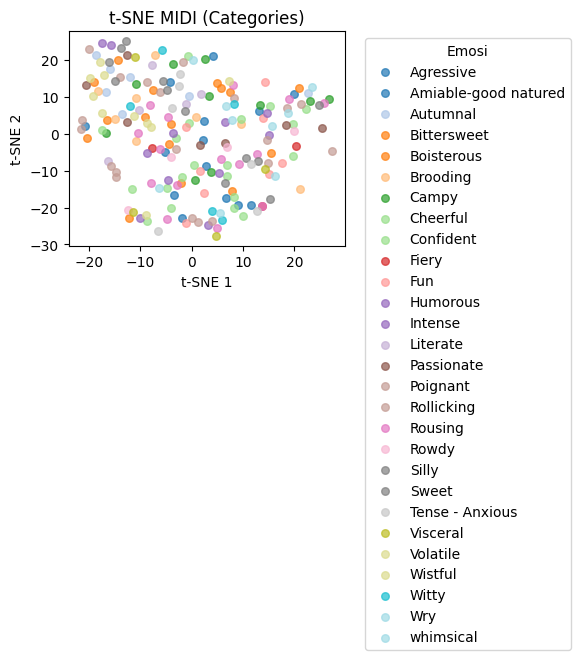

In [150]:
# Visualisasi t-SNE untuk fitur MIDI (kategori)
if X_midi_tsne.size > 0:
    plt.figure(figsize=(6, 5))
    unique_labels_midi = np.unique(y_midi)
    colors_midi = plt.cm.tab20(np.linspace(0, 1, len(unique_labels_midi)))
    label_to_color_midi = {label: color for label, color in zip(unique_labels_midi, colors_midi)}
    for label in unique_labels_midi:
        mask = y_midi == label
        plt.scatter(X_midi_tsne[mask, 0], X_midi_tsne[mask, 1], color=label_to_color_midi[label], alpha=0.7, s=30, label=label)
    plt.title('t-SNE MIDI (Categories)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Emosi', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Lewati plot MIDI: tidak ada data t-SNE.")


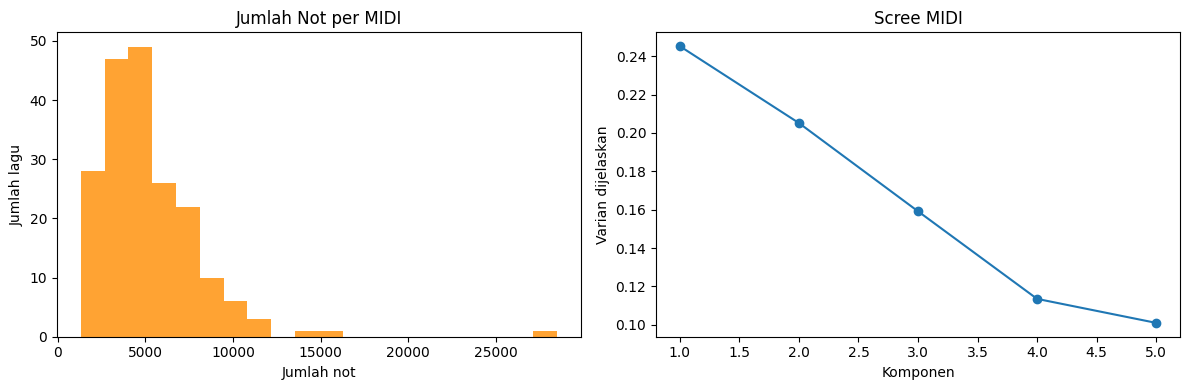

In [151]:
# Histogram jumlah not MIDI dan scree plot MIDI jika tersedia
if X_midi.size > 0 and pca_midi is not None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(midi_note_counts, bins=20, color='darkorange', alpha=0.8)
    plt.title('Jumlah Not per MIDI')
    plt.xlabel('Jumlah not')
    plt.ylabel('Jumlah lagu')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(pca_midi.explained_variance_ratio_)+1), pca_midi.explained_variance_ratio_, marker='o')
    plt.title('Scree MIDI')
    plt.xlabel('Komponen')
    plt.ylabel('Varian dijelaskan')

    plt.tight_layout()
    plt.show()
else:
    print('Histogram/Scree MIDI dilewati karena tidak ada data.')


In [152]:
# Ekstraksi fitur lirik menggunakan TF-IDF
lyrics_texts = []
lyrics_labels = []
lyrics_clusters = []
lyrics_word_counts = []
missing_lyrics_count = 0

for idx, row in metadata.iterrows():
    base = os.path.splitext(str(row['filename']))[0]
    lyric_path = os.path.join(lyrics_dir, base + '.txt')

    if not os.path.isfile(lyric_path):
        missing_lyrics_count += 1
        continue

    try:
        with open(lyric_path, 'r', encoding='utf-8', errors='ignore') as f:
            text = f.read().strip()
        if len(text) == 0:
            continue
        lyrics_texts.append(text)
        lyrics_labels.append(row['label'])
        lyrics_clusters.append(row['cluster'])
        lyrics_word_counts.append(len(text.split()))
    except Exception as e:
        print(f"Gagal membaca lirik {lyric_path}: {e}")
        continue

if len(lyrics_texts) > 0:
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X_lyrics_tfidf = vectorizer.fit_transform(lyrics_texts)
    X_lyrics = X_lyrics_tfidf.toarray()
    y_lyrics = np.array(lyrics_labels)
    y_lyrics_cluster = np.array(lyrics_clusters)
    print("Shape TF-IDF lirik:", X_lyrics.shape)
    print("Contoh kata penting:", vectorizer.get_feature_names_out()[:15])
else:
    X_lyrics = np.array([])
    y_lyrics = np.array([])
    y_lyrics_cluster = np.array([])
    print("Tidak ada lirik yang berhasil diproses.")

print("Jumlah metadata tanpa lirik:", missing_lyrics_count)


Shape TF-IDF lirik: (764, 1000)
Contoh kata penting: ['30' 'aah' 'able' 'act' 'afraid' 'ago' 'ah' 'ahead' 'ahh' 'ahhh' 'ain'
 'air' 'alfie' 'alive' 'alley']
Jumlah metadata tanpa lirik: 138


In [153]:
# PCA dan t-SNE untuk fitur lirik
X_lyrics_tsne = np.array([])
pca_lyrics = None

if X_lyrics.size > 0:
    n_comp_lyrics = max(2, min(50, X_lyrics.shape[0], X_lyrics.shape[1]))
    pca_lyrics = PCA(n_components=n_comp_lyrics, random_state=42)
    X_lyrics_pca = pca_lyrics.fit_transform(X_lyrics)
    print("Shape X_lyrics_pca:", X_lyrics_pca.shape)
    print(f"Total variansi yang dijelaskan {n_comp_lyrics} komponen: {np.sum(pca_lyrics.explained_variance_ratio_):.2%}")

    tsne_lyrics = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=800, random_state=42, init='pca')
    X_lyrics_tsne = tsne_lyrics.fit_transform(X_lyrics_pca)
    print("Shape X_lyrics_tsne:", X_lyrics_tsne.shape)
else:
    print("Tidak ada fitur lirik untuk diproses dengan t-SNE.")


Shape X_lyrics_pca: (764, 50)
Total variansi yang dijelaskan 50 komponen: 27.68%


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Shape X_lyrics_tsne: (764, 2)


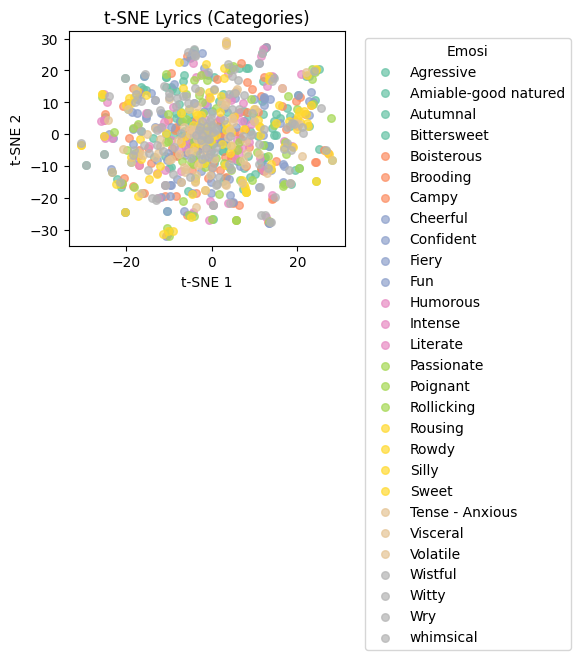

In [154]:
# Visualisasi t-SNE untuk fitur lirik
if X_lyrics_tsne.size > 0:
    plt.figure(figsize=(6, 5))
    unique_labels_lyrics = np.unique(y_lyrics)
    colors_lyrics = plt.cm.Set2(np.linspace(0, 1, len(unique_labels_lyrics)))
    label_to_color_lyrics = {label: color for label, color in zip(unique_labels_lyrics, colors_lyrics)}
    for label in unique_labels_lyrics:
        mask = y_lyrics == label
        plt.scatter(X_lyrics_tsne[mask, 0], X_lyrics_tsne[mask, 1], color=label_to_color_lyrics[label], alpha=0.7, s=30, label=label)
    plt.title('t-SNE Lyrics (Categories)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.legend(title='Emosi', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print('Lewati plot lirik: tidak ada data t-SNE.')


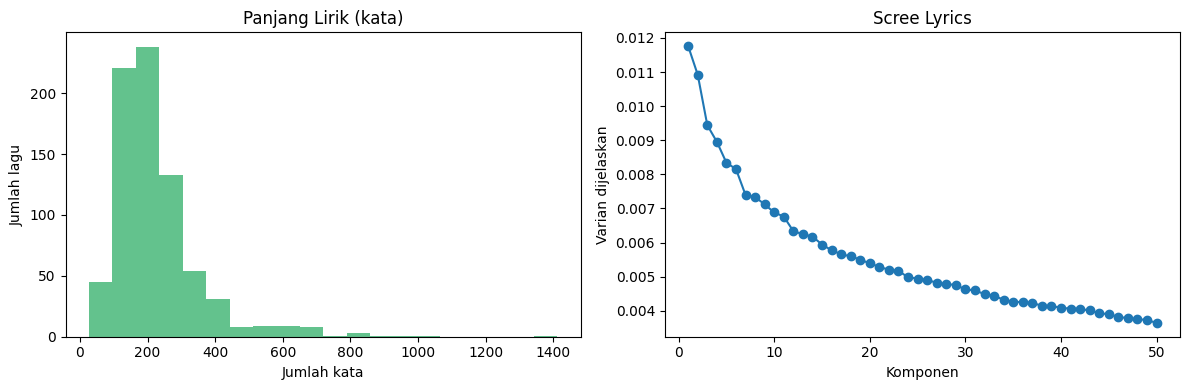

In [155]:
# Histogram panjang lirik dan scree plot lirik jika tersedia
if X_lyrics.size > 0 and pca_lyrics is not None:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(lyrics_word_counts, bins=20, color='mediumseagreen', alpha=0.8)
    plt.title('Panjang Lirik (kata)')
    plt.xlabel('Jumlah kata')
    plt.ylabel('Jumlah lagu')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, len(pca_lyrics.explained_variance_ratio_)+1), pca_lyrics.explained_variance_ratio_, marker='o')
    plt.title('Scree Lyrics')
    plt.xlabel('Komponen')
    plt.ylabel('Varian dijelaskan')

    plt.tight_layout()
    plt.show()
else:
    print('Histogram/Scree lirik dilewati karena tidak ada data.')


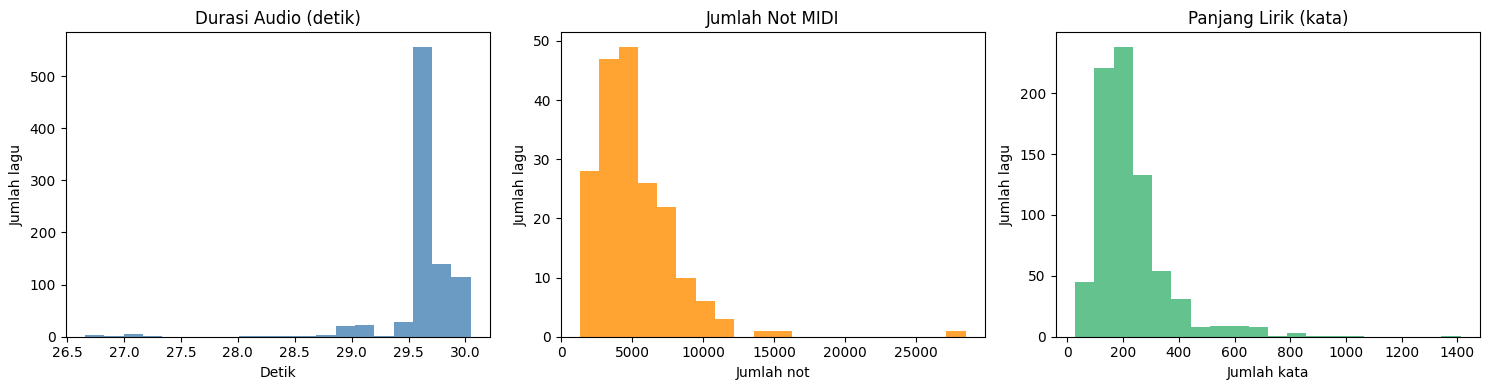

In [156]:
# Ringkasan fitur dasar: durasi audio, jumlah not MIDI, panjang lirik
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(audio_durations, bins=20, color='steelblue', alpha=0.8)
plt.title('Durasi Audio (detik)')
plt.xlabel('Detik')
plt.ylabel('Jumlah lagu')

plt.subplot(1, 3, 2)
if len(midi_note_counts) > 0:
    plt.hist(midi_note_counts, bins=20, color='darkorange', alpha=0.8)
    plt.title('Jumlah Not MIDI')
    plt.xlabel('Jumlah not')
    plt.ylabel('Jumlah lagu')
else:
    plt.text(0.5, 0.5, 'MIDI tidak tersedia', ha='center')
    plt.axis('off')

plt.subplot(1, 3, 3)
if len(lyrics_word_counts) > 0:
    plt.hist(lyrics_word_counts, bins=20, color='mediumseagreen', alpha=0.8)
    plt.title('Panjang Lirik (kata)')
    plt.xlabel('Jumlah kata')
    plt.ylabel('Jumlah lagu')
else:
    plt.text(0.5, 0.5, 'Lirik tidak tersedia', ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()


# Ringkasan Singkat EDA
- Distribusi label: frekuensi kategori (categories.txt) dan cluster (clusters.txt) untuk cek imbalance.
- Kualitas file: proporsi baris metadata yang punya audio/MIDI/lirik; banyak baris memang tidak punya MIDI/lirik sehingga modal tersebut hanya subset.
- Audio: MFCC mean+std -> standar -> PCA -> t-SNE; plot kategori & cluster; variasi perplexity untuk cek stabilitas.
- MIDI: statistik nada/velocity/durasi/tempo -> t-SNE; histogram jumlah not; scree plot PCA.
- Lirik: TF-IDF -> PCA -> t-SNE; histogram panjang lirik; scree plot PCA.
- Korelasi MFCC: heatmap untuk identifikasi dimensi redundan; scree plot membantu pilih jumlah komponen.
- Ide lanjut: gabungkan multimodal (concatenate fitur yang tersedia), coba label alternatif (clusters.txt), tambahkan fitur spektral lain (chroma, spectral centroid), atau pakai encoder pretrained (wav2vec/YAMNet untuk audio, mBERT untuk lirik).